# QOSF screening task 4 - QAOA implementation for Weighted MaxCut problems

## Table of contents

1. [Task definition](#Task-definition)
1. [Background](#Background)
1. [Implementation](#Implementation)
1. [Future improvements](#Future-improvements)
1. [References](#References)

## Task definition

This is the original description, as received:

The [MaxCut problem](https://en.wikipedia.org/wiki/Maximum_cut) is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read [this blogpost](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)).

At this [link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. **We ask you to generalize the above code to include also the solution for the case of weighted graphs**. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.



## Background

### The MaxCut problem
The MaxCut problem is a combinatorial optimization problem that can be defined as follows:

Given a graph $G = (V, E)$ with $V$ vertices and $E$ edges, find a subset $S \in V$ such that the number of edges between $S$ and $S \setminus V$ is maximized ([1]). This is a particular case of weighted MaxCut, where all of the $E$ edges have a weight $w = 1$. For arbitrary weights, the objective becomes to find a subset $S \in V$ such that $\sum_{e \in cut} w_{e}$ is maximized, where $cut \subset E$ is the set of edges connecting $S$ and $S \setminus V$. 

This set of problems is equivalent with the search for the ground state of an antiferromagnetic Ising model.

### Ising model

The Ising model is an objective function of $N$ variables  $s = [s_1,...,s_N]$  corresponding to physical Ising spins, where $h_i$ are the biases and $J_{i,j}$ the couplings (interactions) between spins.

$${E(s|h,J) = \sum_{i=1}^N h_{i} s_{i}+ \sum_{i<j}^N J_{i,j} s_{i}s_{j}} \ \ \ \ \ \ \ \ {s_{i} \in {-1,+1}}$$

### Quantum Approximate Optimization Algorithm (QAOA)
The Quantum Aproximate Optimization Algorithm (QAOA) is a hybrid classical/quantum algorithm that is specialized on solving combinatorial optimization problems on near-term machines. 

QAOA defines the problem as a parametrized objective function that is translated into layered quantum circuits with one and two-qubit gates. The parameters are optimized by classical approaches in order to generate distributions with significant support on the optimal solution.

QAOA only aproximates the optimal solutions and the quality of its approximation depends on increasing the number of layers as part of the trotterization technique. 

Even though QAOA uses different aproaches and only approximates the ground state, by choosing specific sets of parameters QAOA can mimic a time-discretization of Adiabiatic Quantum Computing (AQC). 


QAOA is defined as:
$$ |\gamma, \beta \rangle = U(H_B, \beta_p) U(H_C, \gamma_p) … U(H_B, \beta_1) U(H_C, \gamma_1) | s \rangle$$  $$ U(H_B, \beta) = e^{-i \beta H_B} $$ $$ U(H_C, \gamma) = e^{-i \gamma H_C}$$ 

$ |s\rangle $ is the starting state, usually $|0...0 \rangle$ or $H | 0...0 \rangle = |+...+ \rangle$ and $p$ is usually called “number of steps/layers”.


Applying $U_B$ (mixer operator) and $U_C$ (cost operator) corresponds to evolving the state with the Hamiltonian $H_B$ and $H_C$ for time $\beta$ and $\gamma$. The parameters $\beta$  and $\gamma$ are often called “angles”.



## Implementation

**Input:** A weighted graph. We encode its vertices as a bit string of $0$ and $1$, where the values  represent the 2 partitions. 

**Output:** A bit string of the same shape and format as the encoded input, giving us a computed graph cut.

### Implementation steps:

1. [Encode the problem](#Encode-the-problem)
    * [Define the cost operator $U_{C}$ based on:](#Define-the-cost-operator-$U_{C}$)

    $$H_{C} = \frac{1}{2}\displaystyle \sum_{(i, j) \in E}w_{i,j}(1 - \sigma_i^z\sigma_j^z)$$
    
    * [Define the mixer operator $U_{B}$ based on:](#Define-the-mixer-operator-$U_{B}$)

    $$H_B = \sum_{j=0}^n \sigma_j^x$$
   
1. [Build the circuit](#Build-circuit) 
    * a layer of Hadamard gates to prepare the initial state
    * $p$ layers of $U_C$ and $U_B$ in an alternating fashion
    * a layer of measurement gates 
    
1. [Define objective function](#Define-objective-function)

    * calculate the expected system energy as the average of  
$$cost(cut) = \sum_{e \in cut} w_{e}$$ over all of the cuts generated with the current parameters $\gamma$ and $\beta$
      
1. [Optimize params](#Optimize-parameters)
    * minimize the objective function using the COBYLA optimizer from scipy

1. [Extract and interpret results](#Extract-and-interpret-results)
    * generate a random weighted 3-regular graph
    * set initial parameters
    * get best parameters from runing the optimizer
    * run the circuit with the calculated parameters
    * display best solution
    * calculate and display the energy distribution of the samples

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from networkx.generators.random_graphs import random_regular_graph
from operator import itemgetter
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from scipy.optimize import minimize

In [2]:
np.random.seed(99)

def invert_counts(counts):
    '''Utility function for inverting Qiskit results'''
    return {k[::-1]:v for k, v in counts.items()}

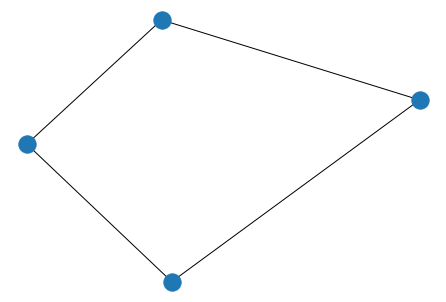

In [3]:
# Sample graph for operator validation
graph = [(0, 1, 10), (0, 3, 20), (1, 2, 30), (2, 3, 42)]

G = nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G)

### Encode the problem

### Define the cost operator $U_{C}$

This can be implemented in qiskit using $P$ and $CP$ gates:

$$P(\theta) = \left[\begin{matrix}
1 & 0 \\
0 & e^{i\theta}
\end{matrix}\right] \ \ \ \ \ \ \ CP(\theta) = \left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\theta}
\end{matrix}\right] \ \ \ \ \ \ \ P(\lambda)\otimes P({\theta}) = \left[\begin{matrix}
1 & 0 & 0 & 0 \\
0 & e^{i\lambda} & 0 & 0 \\
0 & 0 & e^{i\theta} & 0 \\
0 & 0 & 0 & e^{i(\lambda+\theta)}
\end{matrix}\right]$$

This brings us to the following implementation, where the vertices belonging to the same subset won't be affected:

In [4]:
def U_C(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for qj, qk in G.edges():
        qc.cp(-2*gamma, qj, qk)
        qc.p(gamma, qj)
        qc.p(gamma, qk)
    return qc

In [5]:
# Draw U_C for validation
qc = U_C(G, np.pi / 2)
qc.draw()

┌────────┐         ┌────────┐                             
q_0: ────■────┤ P(π/2) ├────■────┤ P(π/2) ├─────────────────────────────
     ┌───┴───┐├────────┤    │    └────────┘┌────────┐                   
q_1: ┤ P(-π) ├┤ P(π/2) ├────┼────────■─────┤ P(π/2) ├───────────────────
     └───────┘└────────┘    │    ┌───┴───┐ ├────────┤┌───────┐┌────────┐
q_2: ───────────────────────┼────┤ P(-π) ├─┤ P(π/2) ├┤ P(-π) ├┤ P(π/2) ├
                        ┌───┴───┐├───────┴┐└────────┘└───┬───┘├────────┤
q_3: ───────────────────┤ P(-π) ├┤ P(π/2) ├──────────────■────┤ P(π/2) ├
                        └───────┘└────────┘                   └────────┘
c: 4/═══════════════════════════════════════════════════════════════════

### Define the mixer operator $U_{B}$


In [6]:
def U_B(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for q in G.nodes():
        qc.rx(2*beta, q)
    return qc

In [7]:
# Draw U_B for validation
qc = U_B(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ RX(2π/3) ├
     ├──────────┤
q_1: ┤ RX(2π/3) ├
     ├──────────┤
q_2: ┤ RX(2π/3) ├
     ├──────────┤
q_3: ┤ RX(2π/3) ├
     └──────────┘
c: 4/════════════

### Build circuit

In [8]:
def qaoa_circ(G, p, betas, gammas):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    qc.h(range(N))
    
    for layer in range(p):
        qc += U_C(G, gammas[layer])
        qc.barrier(range(N))
        qc += U_B(G, betas[layer])
        qc.barrier(range(N))

    qc.measure(range(N), range(N))
    
    return qc

In [9]:
# Draw the full circut for validation
betas = [np.pi/3, np.pi/2]
gammas = [np.pi/6, np.pi/4]
p = 2
qc = qaoa_circ(G, p, betas, gammas)
qc.draw()

┌───┐           ┌────────┐            ┌────────┐                     »
q_0: ┤ H ├─────■─────┤ P(π/6) ├─────■──────┤ P(π/6) ├─────────────────────»
     ├───┤┌────┴────┐├────────┤     │      └────────┘┌────────┐           »
q_1: ┤ H ├┤ P(-π/3) ├┤ P(π/6) ├─────┼──────────■─────┤ P(π/6) ├───────────»
     ├───┤└─────────┘└────────┘     │     ┌────┴────┐├────────┤┌─────────┐»
q_2: ┤ H ├──────────────────────────┼─────┤ P(-π/3) ├┤ P(π/6) ├┤ P(-π/3) ├»
     ├───┤                     ┌────┴────┐└┬────────┤└────────┘└────┬────┘»
q_3: ┤ H ├─────────────────────┤ P(-π/3) ├─┤ P(π/6) ├───────────────■─────»
     └───┘                     └─────────┘ └────────┘                     »
c: 4/═════════════════════════════════════════════════════════════════════»
                                                                          »
«                ░ ┌──────────┐ ░            ┌────────┐            ┌────────┐»
«q_0: ───────────░─┤ RX(2π/3) ├─░──────■─────┤ P(π/4) ├─────■──────┤ P(π/4) ├»
«                ░ ├──────────┤ ░ ┌────┴────┐├────────┤     │      └────────┘»
«q_1: ───────────░─┤ RX(2π/3) ├─░─┤ P(-π/2) ├┤ P(π/4) ├─────┼──────────■─────»
«     ┌────────┐ ░ ├──────────┤ ░ └─────────┘└────────┘     │     ┌────┴────┐»
«q_2: ┤ P(π/6) ├─░─┤ RX(2π/3) ├─░───────────────────────────┼─────┤ P(-π/2) ├»
«     ├────────┤ ░ ├──────────┤ ░                      ┌────┴────┐└┬────────┤»
«q_3: ┤ P(π/6) ├─░─┤ RX(2π/3) ├─░──────────────────────┤ P(-π/2) ├─┤ P(π/4) ├»
«     └────────┘ ░ └──────────┘ ░                      └─────────┘ └────────┘»
«c: 4/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                     ░ ┌───────┐ ░ ┌─┐         
«q_0: ────────────────────────────────░─┤ RX(π) ├─░─┤M├─────────
«     ┌────────┐                      ░ ├───────┤ ░ └╥┘┌─┐      
«q_1: ┤ P(π/4) ├──────────────────────░─┤ RX(π) ├─░──╫─┤M├──────
«     ├────────┤┌─────────┐┌────────┐ ░ ├───────┤ ░  ║ └╥┘┌─┐   
«q_2: ┤ P(π/4) ├┤ P(-π/2) ├┤ P(π/4) ├─░─┤ RX(π) ├─░──╫──╫─┤M├───
«     └────────┘└────┬────┘├────────┤ ░ ├───────┤ ░  ║  ║ └╥┘┌─┐
«q_3: ───────────────■─────┤ P(π/4) ├─░─┤ RX(π) ├─░──╫──╫──╫─┤M├
«                          └────────┘ ░ └───────┘ ░  ║  ║  ║ └╥┘
«c: 4/═══════════════════════════════════════════════╩══╩══╩══╩═
«                                                    0  1  2  3

### Define objective function


In [10]:
def maxcut_cost(cut, G):
    cut_cost = 0
    for i, j in G.edges():
        if cut[i] != cut[j]: # the edge is cut
            cut_cost -= G[i][j]['weight']

    return cut_cost
# maxcut_cost('00110', G)

In [11]:
def compute_energy(samples, G):
    '''Compute the average energy over all of the samples'''
    energy = 0
    total_counts = 0
    
    for cut, cut_count in samples.items():
        energy += maxcut_cost(cut, G) * cut_count 
        total_counts += cut_count
    
    return energy / total_counts

In [12]:
def objective_fn(theta, G, p, backend):
    '''Objective function to be minimized by the optimizer'''
    beta = theta[:p]
    gamma = theta[p:]
    
    qc = qaoa_circ(G, p, beta, gamma)
    counts = execute(qc, backend, seed_simulator=10).result().get_counts()
   
    return compute_energy(invert_counts(counts), G)


### Optimize parameters

In [13]:
def optimize(objective_fn, init_point, p, G, backend, optimizer='COBYLA'):
    
    res_sample = minimize(objective_fn, init_point, args=(G, p, backend), 
                      method='COBYLA', options={'maxiter':2000, 'disp': True})
    optimal_theta = res_sample['x']
    
    return res_sample, optimal_theta


### Extract and interpret results

In [14]:
def draw_graph(G, colors=None):
    labels = nx.get_edge_attributes(G, 'weight')
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos, node_size=550, node_color=colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

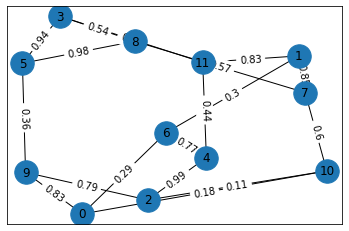

In [15]:
def generate_graph(degree, nodes):
    '''Generate a n-degree regular weighted graph'''
    G = random_regular_graph(degree, nodes, seed=42)
    for (u,v,w) in G.edges(data=True):
        w['weight'] = round(np.random.uniform(0.1, 1.0), 2)
    
    return G

G = generate_graph(3, 12)

draw_graph(G)

In [16]:
# Set initial parameters

p = 6
gammas = np.random.uniform(0, 2*np.pi,[p])
betas = np.random.uniform(0, np.pi,[p])

init_point = [*gammas, *betas]
backend = Aer.get_backend('qasm_simulator')

In [17]:
# Run the optimizer
res_sample, optimal_theta = optimize(objective_fn, init_point, p, G, backend, optimizer='COBYLA')
res_sample

     fun: -8.31409179687499
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 155
  status: 1
 success: True
       x: array([3.32203343, 2.31733262, 1.02022922, 5.78416645, 6.10514605,
       4.99061848, 1.1325807 , 2.21531321, 2.73899017, 0.16290989,
       1.27916377, 1.97901946])

Best string: 010110001110 with cut: 10.0


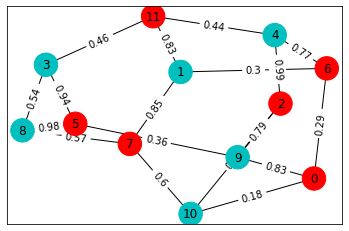

In [18]:
# Run the circuit with the optimal generated parameters

qc = qaoa_circ(G, p, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())

# Get the best solution
best_solution, best_cut  = min([(cut, maxcut_cost(cut, G)) for cut in counts.keys()], key=itemgetter(1))

# Color the graph nodes by partition
colors = ['r' if best_solution[node] == '0' else 'c' for node in G]
draw_graph(G, colors=colors)

print(f"Best string: {best_solution} with cut: {-best_cut}")

<BarContainer object of 158 artists>

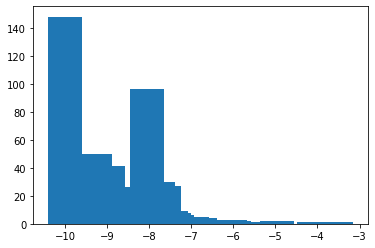

In [19]:
def get_energies(counts):
    '''Count the energy values of the samples'''
    energies = defaultdict(int)
    
    for k, v in counts.items():
        energies[maxcut_cost(k,G)] += v
    
    return energies


energs = get_energies(counts)
x,y = zip(*energs.items())
plt.bar(x,y)

We notice that most of the results correspond to good solutions as minimizing the average energy of the samples greatly increases the number of solutions that have near minimum energy.

Even though the resulting solution with the highest probability can be suboptimal, QAOA is a good approach for solving the MaxCut problem for weighted graphs and it helps define an upper bound of the solution space, very close to the optimal solution.

Increasing the $p$ parameter can improve even more the overall obtained energy.

## Future improvements

A few points in the implementation can be improved in future work:

* Choosing better initial points for $\gamma$ and $\beta$ parameters: there are additional strategies ([2]) that can greatly improve the optimization process, such as the **FOURIER** strategy, which computes  $\gamma$, $\beta$ parameters using a $sin$/$cos$ transform and avoids getting the optimizer stuck in points of local minimum by adding perturbations.

* Limiting the number of qubits: the current approach uses a number of qubits equal to the number of graph nodes which limits the size of the graphs that can be processed with this algorithm. 

### References

1. [Performance of the Quantum Approximate Optimization Algorithm on the Maximum Cut Problem](https://arxiv.org/pdf/1811.08419.pdf)
1. [Quantum Approximate Optimization Algorithm: Performance, Mechanism, and
Implementation on Near-Term Devices](https://arxiv.org/pdf/1812.01041.pdf)
1. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)
1. [Quantum Approximate Optimization Algorithm explained](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)
1. [Combinatorial Optimization on Quantum Computers](https://github.com/rsln-s/IEEE_QW_2020)
1. [Qiskit textbook](https://qiskit.org/textbook/ch-applications/qaoa.html)
1. [QAOA for MaxCut](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html)
